# MIXED CRITICAL EARLIEST DEADLINE FIRST

**Research Paper:** Mixed Critical Earliest Deadline First

**Conference:** Euromicro Conference on Real-Time Systems

**Authors:** 

- Dario Socci, University Joseph Fourier
- Peter Poplavko, Mentor A Siemens Business
- Sadek Bensalem, Christian-Albrechts-Universitat zu Kiel

**Published in:** July, 2013


# MCEDF

## Mixed Critical Earliest Deadline First (MCEDF) Scheduling

The proposed MCEDF algorithm computes a Priority Table (*PT*) for Fixed Priority per Mode (FPM) policy.

**Approach:**
- Initially, we compute the schedulability of LO scenario in subroutine LOscenarioFailure, by running EDF.
- By optimality of EDF for single criticality level, if a job misses the deadline, then the instance is not schedulable.
- To compute the final priority table, the MCEDF algorithm first calls subroutine GeneratePriorityTree, which generates constraints on the priorities. 
- These constraints are represented by a directed graph G. 
- Every node in G associates to a unique job, and every edge to a ‘strictly greater than’ constraint between the job priorities, thus G defines a partial order on job priorities.
- Finally, the subroutine anyHIscenarioFailure evaluates whether Condition 2 is met.

The check is done by a simulation over the set of all basic HI scenarios where a particular HI job is the first in the schedule to switch to the HI mode and all the HI jobs that execute after the switch conservatively use the C(HI) execution times.

In [ ]:
# Import the required Python libraries

import pandas as pd
from numpy import partition
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time

In [ ]:
# Creating job instances for scheduling

columns = ['unique_index', 'arrival_time', 'deadline', 'criticality_level', 'lo_wcet', 'hi_wcet']

job1 = [[1, 0, 17, 'LO', 2, 2],
        [2, 0, 18, 'HI', 4, 5]]

job2 = [[1, 0, 5, 'HI', 2, 3],
       [2, 0, 6, 'HI', 1, 2],
       [3, 0, 4, 'LO', 2, 2]]

job3 = [[1, 0, 3, 'LO', 2, 2],
        [2, 3, 4, 'LO', 1, 1],
        [3, 3, 5, 'HI', 1, 1],
        [4, 0, 6, 'HI', 1, 4]]

job4 = [[1, 0, 30, 'HI', 10, 12],
        [2, 2, 10, 'HI', 2, 8],
        [3, 1, 18, 'LO', 2, 2],
        [4, 8, 17, 'HI', 2, 7],
        [5, 7, 11, 'LO', 2, 2]]

job5   = [[1, 0, 11, 'HI', 10, 12],
        [2, 2, 10, 'HI', 2, 8],
        [3, 1, 8, 'LO', 2, 2],
        [4, 8, 17, 'HI', 2, 7],
        [5, 7, 11, 'LO', 2, 2],
        [6, 7, 20, 'LO', 3, 3]]



job1 = pd.DataFrame(job1, columns=columns)
job2 = pd.DataFrame(job2, columns=columns)
job3 = pd.DataFrame(job3, columns=columns)
job4 = pd.DataFrame(job4, columns=columns)
job5 = pd.DataFrame(job5, columns=columns)

In [ ]:
# Printing one instance of job

job5

,unique_index,arrival_time,deadline,criticality_level,lo_wcet,hi_wcet
0,1,0,11,HI,10,12
1,2,2,10,HI,2,8
2,3,1,8,LO,2,2
3,4,8,17,HI,2,7
4,5,7,11,LO,2,2
5,6,7,20,LO,3,3


In [ ]:
def get_edf_priority(jobs):
  '''
  To get the priorities of tasks by applying Earliest Deadline First scheduling
  '''
  # Sort the tasks on the basis of their deadline
  sorted_jobs = jobs.sort_values(['deadline'])
  return list(sorted_jobs['unique_index'])

#edf_priorities = get_edf_priority(job2)
#edf_priorities

In [ ]:
def schedule_jobs_on_low_criticality(jobs,priorities):
  '''
  To schedule the given jobs with the given priority sequence  
  '''
  completion_times = {}
  job_arrival_times = {}
  job_active_runtimes = {}
  start_time = {}
  end_time = {}
  start_end_time = {}
  # Map each time unit with job id
  schedule = {}
  t = 0
  scheduled_jobs = 0
  total_jobs = len(jobs)
  is_started = [False] * total_jobs
  total_runtime = jobs['lo_wcet'].sum()
  # Extract the required metrics
  for i in range(1, total_jobs + 1):
    job_arrival_times[i] = int(jobs[jobs['unique_index'] == i]['arrival_time'])
    job_active_runtimes[i] = int(jobs[jobs['unique_index'] == i]['lo_wcet'])
  # For each time unit
  while scheduled_jobs < total_jobs:
    ready_jobs = []
    # Traverse through the list of jobs
    for job in range(1, total_jobs + 1):
      # Identify the jobs in ready state
      if job_arrival_times[job] <= t and job_active_runtimes[job] > 0:
        ready_jobs.append(job)
    # Check if processor is idle
    if not len(ready_jobs):
      schedule[t] = -1
    # Execute ready job with highest priority
    else:
      for p in priorities:
        if p in ready_jobs:
          schedule[t] = p
          job_active_runtimes[p] -= 1
          if not is_started[p-1]:
            is_started[p-1] = True
            start_time[p] = t
          # Check if job has ended
          if not job_active_runtimes[p]:
            scheduled_jobs += 1
            start_end_time[p] = {'start_time': start_time[p],
                                 'end_time': t+1}
          break
    t += 1
  return schedule, start_end_time

#schedule, start_end_time = schedule_jobs_on_low_criticality(job2,edf_priorities)
#schedule, start_end_time

In [ ]:
def schedule_jobs_on_high_criticality(jobs,priorities):
  '''
  To schedule the given jobs with the given priority sequence  
  '''
  hi_jobs = jobs[jobs['criticality_level'] == 'HI']
  hi_job_ids = list(hi_jobs['unique_index'])

  job_arrival_times = {}
  job_active_runtimes = {}
  start_time = {}
  end_time = {}
  start_end_time = {}

  # Map each time unit with job id
  schedule = {}

  t = 0
  scheduled_jobs = 0
  total_jobs = len(hi_jobs)
  is_started = dict(zip([i for i in hi_job_ids], [False for _ in range(1, total_jobs + 1)]))
  total_runtime = jobs['hi_wcet'].sum()

  # Extract the required metrics
  for job_id in list(hi_jobs['unique_index']):
    job_arrival_times[job_id] = int(hi_jobs[hi_jobs['unique_index'] == job_id]['arrival_time'])
    job_active_runtimes[job_id] = int(hi_jobs[hi_jobs['unique_index'] == job_id]['hi_wcet'])

  # For each time unit
  while scheduled_jobs < total_jobs:
    ready_jobs = []

    # Traverse through the list of jobs
    for job in list(hi_jobs['unique_index']):
  
      # Identify the jobs in ready state
      if job_arrival_times[job] <= t and job_active_runtimes[job] > 0:
        ready_jobs.append(job)

    # Check if processor is idle
    if not len(ready_jobs):
      schedule[t] = -1

    # Execute ready job with highest priority
    else:
      for p in priorities:
        if p in ready_jobs:
          schedule[t] = p
          job_active_runtimes[p] -= 1

          if not is_started[p]:
            is_started[p] = True
            start_time[p] = t

          # Check if job has ended
          if not job_active_runtimes[p]:
            scheduled_jobs += 1
            start_end_time[p] = {'start_time': start_time[p],
                                 'end_time': t+1}
          break

    t += 1

  return schedule, start_end_time



In [ ]:
def check_criticality_failure(jobs,start_end_time):
  '''
  To schedule all tasks in low criticality mode
  '''
  deadlines = {}
  is_failure = False
  total_jobs = len(jobs)
  # For each job
  for i in range(1, total_jobs + 1):
    job_deadline = int(jobs[jobs['unique_index'] == i]['deadline'])
    # Check if the completion time exceeds its deadline
    if start_end_time[i]['end_time'] > job_deadline:
      is_failure = True
      break
  return is_failure

#is_low_criticality_failure = check_low_criticality_failure(job3,start_end_time)
#is_low_criticality_failure

In [ ]:
def topologicalSortUtil(graph,v, visited, stack,lev,level):
    '''
    Helper function for topological sorting
    '''
    visited[v] = True
    for i in graph[v]:
        if(visited[i] == False):
            level[lev].append(i)
            topologicalSortUtil(graph,i, visited, stack,lev+1,level)
    stack.append(v)

def topologicalSort(J,graph):
    '''
    Topological sorting
    '''
    V=len(J)+1
    visited = [False]*(V)
    stack = []
    level = defaultdict(list)
    for i in range(1,V):
        if visited[i] == False:
            level[len(level)+1].append(i)
            topologicalSortUtil(graph,i, visited, stack,len(level)+1,level)
    '''PT=[]
    print(level)
    kp=list(level.keys())
    kp.reverse()
    for i in kp:
        PT+=level[i]'''
    return (stack) 
    #return PT

In [ ]:
def find_par(sch,J,graph,par,bi):
    '''
    Function to return parent based on busy interval
    '''
    latlo=-2
    lathi=-2
    print("Busy Interval {}".format(bi))
    if(len(bi)==2 and sch[bi[0]]==sch[bi[1]]):
        return sch[bi[0]]
    else:
        for i in range(bi[1],bi[0]-1,-1):
            if(J.iloc[sch[i]-1][3]=='HI' and lathi==-2):
                lathi=sch[i]
            elif(J.iloc[sch[i]-1][3]=='LO' and latlo==-2):
                latlo=sch[i]
            if(latlo!=-2 and lathi!=-2):
                break
        if(J.iloc[latlo-1][2]<=bi[1]):
            return lathi
        else:
            return latlo


In [ ]:
def GeneratePriorityTree(sch,J,graph,par,bi):
    '''
    Function to generate Priority Tree
    '''
    B=find_par(sch,J,graph,par,bi)
    print("Parent in above Busy interval = {}".format(B))
    if(par!=-1):
        graph[par].append(B)
        #graph[B].append(par)
    st,en=-1,-1
    if(bi[0]==bi[1]):
        graph[par].append(sch[bi[0]])
        return graph
    else:
        bnn=[]
        for i in range(bi[0],bi[1]+1,1):
            if(sch[i]!=B):
                bnn.append(i)
                if(i==bi[1]):
                    GeneratePriorityTree(sch,J,graph,B,(bnn[0],bnn[len(bnn)-1]))
            elif(sch[i]==B):
                if(len(bnn)>0):
                    GeneratePriorityTree(sch,J,graph,B,(bnn[0],bnn[len(bnn)-1]))
                    bnn=[]
                else:
                    continue
    return graph

In [ ]:
def make_schedule(schedule):
    '''
    helper function for mcedf
    '''
    k=list(schedule.keys())
    sch=[]
    for i in range(len(k)):
        sch.append(schedule[k[i]])
    return sch

In [ ]:
def check_high_criticality_failure(jobs,start_end_time):
  '''
  To schedule all tasks in low criticality mode
  '''
  hi_jobs = jobs[jobs['criticality_level'] == 'HI']
  hi_job_ids = list(hi_jobs['unique_index'])

  deadlines = {}
  is_failure = False
  total_jobs = len(hi_jobs)

  # For each job
  for i in hi_job_ids:
    job_deadline = int(jobs[jobs['unique_index'] == i]['deadline'])

    # Check if the completion time exceeds its deadline
    if start_end_time[i]['end_time'] > job_deadline:
      is_failure = True
      break
  return is_failure

In [ ]:
def draw_gantt_chart(jobs,schedule, criticality):
  '''
  To plot the Gantt chart for the given schedule
  '''
  runtime = {}
  task_ids = list(set(schedule.values()))
  end_time = max(schedule.keys())
  total_tasks = len(task_ids)

  for k, v in schedule.items():

    if v in runtime:
      runtime[v].append((k, 1))
    else:
      runtime[v] = [(k, 1)]

  fig, gnt = plt.subplots()

  # Setting limits
  gnt.set_xlim(0, end_time + 1)
  gnt.set_ylim(0, total_tasks * 4)
 
  gnt.set_yticks([4 * i + 2 for i in range(total_tasks)])
  yticklabels = ['Job {}'.format(i) for i in task_ids]
  yticklabels.reverse()
  gnt.set_yticklabels(yticklabels)

  # Setting labels
  gnt.set_xlabel('Schedule')
  gnt.set_ylabel('Jobs')

  if criticality == 'LO':
    gnt.set_title('LO Criticality Scheduling')
  else:
    gnt.set_title('HI Criticality Scheduling')
 
  sorted_runtime = list(runtime.keys())
  sorted_runtime.sort()

  # Declaring a bar in schedule
  for k in sorted_runtime:
    if str(jobs[jobs['unique_index'] == k]['criticality_level'].iat[0]) == 'HI':
      gnt.broken_barh(runtime[k], ((total_tasks - sorted_runtime.index(k) - 1) * 4, 4), facecolors=('tab:red'))
    else:
      gnt.broken_barh(runtime[k], ((total_tasks - sorted_runtime.index(k) - 1) * 4, 4), color='tab:blue')



In [ ]:
def mcedf(J):
    '''
    Main Function of MCEDF
    '''
    PT=get_edf_priority(J)
    print('Initial Priority of Jobs based on EDF on LO scanario {}'.format(PT))
    #print(PT)
    schedule, start_end_time = schedule_jobs_on_low_criticality(J,PT)
    if(check_criticality_failure(J,start_end_time)):
        return False
    print()
    print("LO Scenario Passed")
    #PT=InproveHIJobs(PT,J)
    sch=make_schedule(schedule)
    print()
    print('Scheduling of Jobs on LO criticality {}'.format(sch))
    #sch=[3,3,1,1,2]
    graph = defaultdict(list)
    G=GeneratePriorityTree(sch,J,graph,-1,(0,len(sch)-1))
    print()
    print("Priority Tree Formed = {}".format(G))
    PT=topologicalSort(J,G)
    #PT=BFS(J,G,1)
    #print(PT)
    schedule, start_end_time=schedule_jobs_on_high_criticality(J,PT)
    if(check_high_criticality_failure(J,start_end_time)):
        return False
    print()
    print("HI Scenario Passed")
    return PT


In [ ]:
x=["Job1","Job2","Job3","Job4","Job5"]
y_mcedf=[]
y_ocbp=[]
sch_m=0
sch_o=0

# Running on Job-1 Instance

In [ ]:
a=time()
PT=mcedf(job1)
b=time()
y_mcedf.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    print("Final Priority of Jobs using MCEDF will be")
    sch_m+=1
    print(PT)


Initial Priority of Jobs based on EDF on LO scanario [1, 2]

LO Scenario Passed

Scheduling of Jobs on LO criticality [1, 1, 2, 2, 2, 2]
Busy Interval (0, 5)
Parent in above Busy interval = 1
Busy Interval (2, 5)
Parent in above Busy interval = 2

Priority Tree Formed = defaultdict(<class 'list'>, {1: [2]})

HI Scenario Passed

Final Priority of Jobs using MCEDF will be
[2, 1]


{0: 2, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1}


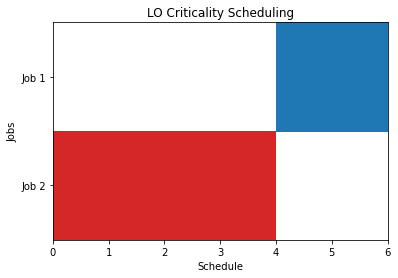

In [ ]:
schedule, start_end_time = schedule_jobs_on_low_criticality(job1,PT)
print(schedule)
draw_gantt_chart(job1,schedule,'LO')


{0: 2, 1: 2, 2: 2, 3: 2, 4: 2}


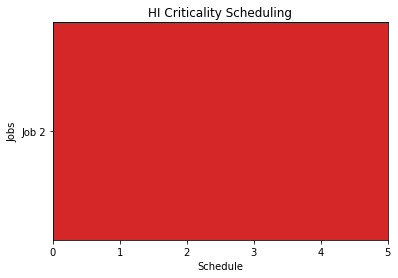

In [ ]:
schedule, start_end_time=schedule_jobs_on_high_criticality(job1,PT)
print(schedule)
draw_gantt_chart(job1,schedule,'HI')

# Running on Job-2 Instance

In [ ]:
a=time()
PT=mcedf(job2)
b=time()
y_mcedf.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_m+=1
    print("Final Priority of Jobs using MCEDF will be")
    print(PT)

Initial Priority of Jobs based on EDF on LO scanario [3, 1, 2]

LO Scenario Passed

Scheduling of Jobs on LO criticality [3, 3, 1, 1, 2]
Busy Interval (0, 4)
Parent in above Busy interval = 2
Busy Interval (0, 3)
Parent in above Busy interval = 3
Busy Interval (2, 3)
Parent in above Busy interval = 1

Priority Tree Formed = defaultdict(<class 'list'>, {2: [3], 3: [1]})

HI Scenario Passed

Final Priority of Jobs using MCEDF will be
[1, 3, 2]


{0: 1, 1: 1, 2: 3, 3: 3, 4: 2}


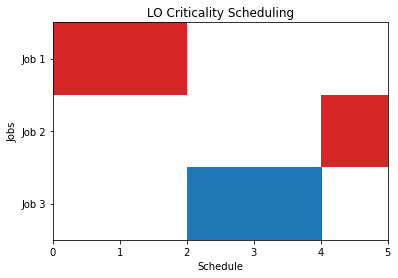

In [ ]:
schedule, start_end_time = schedule_jobs_on_low_criticality(job2,PT)
print(schedule)
draw_gantt_chart(job2,schedule,'LO')


{0: 1, 1: 1, 2: 1, 3: 2, 4: 2}


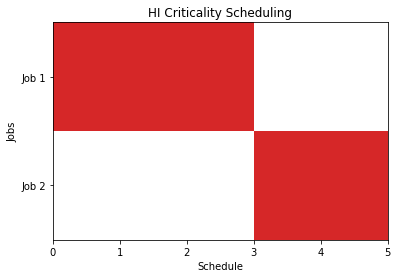

In [ ]:
schedule, start_end_time=schedule_jobs_on_high_criticality(job2,PT)
print(schedule)
draw_gantt_chart(job2,schedule,'HI')

# Running on Job-3 Instance

In [ ]:
a=time()
PT=mcedf(job3)
b=time()
y_mcedf.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_m+=1
    print("Final Priority of Jobs using MCDEDF will be")
    print(PT)

Initial Priority of Jobs based on EDF on LO scanario [1, 2, 3, 4]

LO Scenario Passed

Scheduling of Jobs on LO criticality [1, 1, 4, 2, 3]
Busy Interval (0, 4)
Parent in above Busy interval = 3
Busy Interval (0, 3)
Parent in above Busy interval = 2
Busy Interval (0, 2)
Parent in above Busy interval = 1
Busy Interval (2, 2)
Parent in above Busy interval = 4

Priority Tree Formed = defaultdict(<class 'list'>, {3: [2], 2: [1], 1: [4, 4]})

HI Scenario Passed

Final Priority of Jobs using MCDEDF will be
[4, 1, 2, 3]


{0: 4, 1: 1, 2: 1, 3: 2, 4: 3}


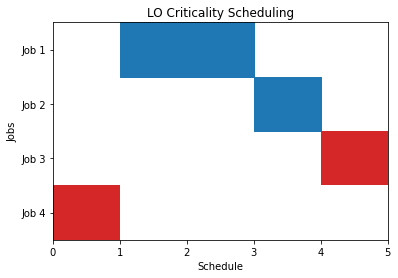

In [ ]:
schedule, start_end_time = schedule_jobs_on_low_criticality(job3,PT)
print(schedule)
draw_gantt_chart(job3,schedule,'LO')


{0: 4, 1: 4, 2: 4, 3: 4, 4: 3}


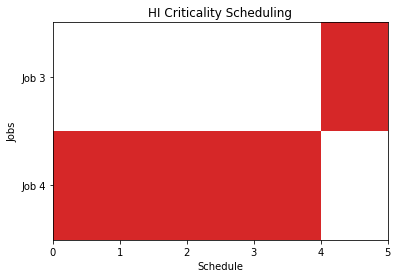

In [ ]:
schedule, start_end_time=schedule_jobs_on_high_criticality(job3,PT)
print(schedule)
draw_gantt_chart(job3,schedule,'HI')

# Running on Job-4 Instance

In [ ]:
a=time()
PT=mcedf(job4)
b=time()
y_mcedf.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_m+=1
    print("Final Priority of Jobs using MCDEDF will be")
    print(PT)

Initial Priority of Jobs based on EDF on LO scanario [2, 5, 4, 3, 1]

LO Scenario Passed

Scheduling of Jobs on LO criticality [1, 3, 2, 2, 3, 1, 1, 5, 5, 4, 4, 1, 1, 1, 1, 1, 1, 1]
Busy Interval (0, 17)
Parent in above Busy interval = 1
Busy Interval (1, 4)
Parent in above Busy interval = 3
Busy Interval (2, 3)
Parent in above Busy interval = 2
Busy Interval (7, 10)
Parent in above Busy interval = 5
Busy Interval (9, 10)
Parent in above Busy interval = 4

Priority Tree Formed = defaultdict(<class 'list'>, {1: [3, 5], 3: [2], 5: [4]})

HI Scenario Passed

Final Priority of Jobs using MCDEDF will be
[2, 3, 4, 5, 1]


{0: 1, 1: 3, 2: 2, 3: 2, 4: 3, 5: 1, 6: 1, 7: 5, 8: 4, 9: 4, 10: 5, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1}


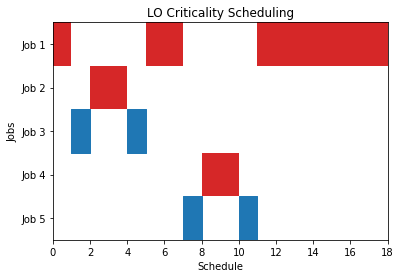

In [ ]:
schedule, start_end_time = schedule_jobs_on_low_criticality(job4,PT)
print(schedule)
draw_gantt_chart(job4,schedule,'LO')


{0: 1, 1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 4, 11: 4, 12: 4, 13: 4, 14: 4, 15: 4, 16: 4, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1}


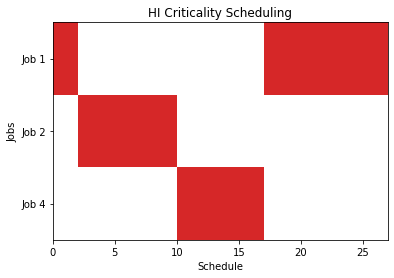

In [ ]:
schedule, start_end_time=schedule_jobs_on_high_criticality(job4,PT)
print(schedule)
draw_gantt_chart(job4,schedule,'HI')

# Running on Job-5 Instance

In [ ]:
a=time()
PT=mcedf(job5)
b=time()
y_mcedf.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_m+=1
    print("Final Priority of Jobs using MCDEDF will be")
    print(PT)

Initial Priority of Jobs based on EDF on LO scanario [3, 2, 1, 5, 4, 6]

Not Schedulable




## Own Criticality Based Priority (OCBP) Scheduling

OCBP was theoretically the best among all fixed job priority scheduling algorithms for Mixed Critical Systems (MCS).

**Approach:**

- The priorities are assigned by repeatedly assigning the least priority, i.e. the last position in Priority Table (*PT*), to a job that will meet its deadline even when executing at the least priority.

- The job that has got the least priority assigned is removed from the working set of jobs as it has no impact on the behavior of the higher priority jobs.

- This procedure is repeated in multiple steps until no jobs remain in the working set.

- If at some point, no job can be selected for the least priority in the set the the instance is considered non-schedulable.

**Note:** The execution time available for a job in a fixed priority scheduling algorithm depends on the arrival and execution of jobs with a higher priority, but not on their relative priority assignment. 

In [ ]:
def ocbp(j,job,PT,all_j,max_depth,p):
  #print("all jobs {}".format(all_j))
  a_w=[]
  critical=job.iloc[j-1][3]
  at=job.iloc[j-1][1]
  wc=0
  #print(PT)
  if(len(all_j)==1):
    #print(all_j)
    PT.append(all_j[0])
    #print(all_j)
    #print("all jobs {}".format(PT))
    print("Job {} is selected".format(j))
    print("Remaining jobs as of now {}".format(all_j))
    print("Priority as of now {}".format(PT[::-1]))
    return PT[::-1]
  if(p>max_depth):
    return False
  if(critical=='LO'):
    wc=job.iloc[j-1][4]
  else:
    wc=job.iloc[j-1][5]
  for i in range(len(job)):
    if(job.iloc[i][0] in all_j):
      if(job.iloc[i][0]!=j):
        if(critical=='LO'):
          a_w.append((job.iloc[i][1],job.iloc[i][4]))
        else:
          a_w.append((job.iloc[i][1],job.iloc[i][5]))
  a_w=sorted(a_w)
  #print(a_w)
  sl=0
  if(a_w[0][0]>at):
    sl+=a_w[0][0]
    wc-=a_w[0][0]
    if(wc==0 and job.iloc[j-1][2]<=sl):
      PT.append(j)
      all_j.remove(j)
      all_j=sorted(all_j)
      print("Job {} is selected".format(j))
      print("Remaining jobs as of now {}".format(all_j))
      print("Priority as of now {}".format(PT[::-1]))
      ocbp(all_j[0],job,PT,all_j,max_depth,p+1)
  else:
    for i in range(len(a_w)):
      if(a_w[i][0]<=sl):
        sl+=a_w[i][1]
      else:
        tp=a_w[i][0]-sl
        sl+=tp
        #print(sl,wc)
        #if(job.iloc[j-1][2]<=sl):
        #print(wc,tp)
        if(job.iloc[j-1][1]<sl):
          wc-=(min(tp,wc)-(job.iloc[j-1][1]))
          #print(wc,tp)
          #print(job.iloc[j-1][2],wc)
          if(wc<=0 and job.iloc[j-1][2]<=sl):
            PT.append(j)
            all_j.remove(j)
            all_j=sorted(all_j)
            #print("AV")
            print("Job {} is selected".format(j))
            print("Remaining jobs as of now {}".format(all_j))
            print("Priority as of now {}".format(PT[::-1]))
            return ocbp(all_j[0],job,PT,all_j,max_depth,p+1)
            
        else:
          sl+=a_w[i][1]
      '''if(i==0):
        sl+=a_w[i][0]+a_w[i][1]
      else:
        if(sl<a_w[i][0]):
          sl+=(a_w[i][0]-sl)+a_w[i][1]
        else:
          sl+=a_w[i][1]'''
  sl+=wc
  #print(sl)
  if(job.iloc[j-1][2]>=sl):
    PT.append(j)
    all_j.remove(j)
    all_j=sorted(all_j)
    print("Job {} is selected".format(j))
    print("Remaining jobs as of now {}".format(all_j))
    print("Priority as of now {}".format(PT[::-1]))
    return ocbp(all_j[0],job,PT,all_j,max_depth,p+1)
  else:
    all_j=sorted(all_j)
    n=0
    for i in range(len(all_j)):
      if(all_j[i]==j):
        n=i+1
        break
    if(n>len(all_j)-1):
      n=0
    return ocbp(all_j[n],job,PT,all_j,max_depth,p+1)


# Running on Job-1 Instance

In [ ]:
all_j=[i+1 for i in range(len(job1))]
max_depth=len(all_j)**2
a=time()
PT=ocbp(1,job1,[],all_j,max_depth,0)
b=time()
y_ocbp.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_o+=1
    print("Final Priority of Jobs using OCBP will be")
    print(PT)

Job 1 is selected
Remaining jobs as of now [2]
Priority as of now [1]
Job 2 is selected
Remaining jobs as of now [2]
Priority as of now [2, 1]

Final Priority of Jobs using OCBP will be
[2, 1]


# Running on Job-2 Instance

In [ ]:
all_j=[i+1 for i in range(len(job2))]
max_depth=len(all_j)**2
a=time()
PT=ocbp(1,job2,[],all_j,max_depth,0)
b=time()
y_ocbp.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_o+=1
    print("Final Priority of Jobs using OCBP will be")
    print(PT)


Not Schedulable


# Running on Job-3 Instance

In [ ]:
all_j=[i+1 for i in range(len(job3))]
max_depth=len(all_j)**2
a=time()
PT=ocbp(1,job3,[],all_j,max_depth,0)
b=time()
y_ocbp.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_o+=1
    print("Final Priority of Jobs using OCBP will be")
    print(PT)

Job 1 is selected
Remaining jobs as of now [2, 3, 4]
Priority as of now [1]
Job 4 is selected
Remaining jobs as of now [2, 3]
Priority as of now [4, 1]
Job 3 is selected
Remaining jobs as of now [2]
Priority as of now [3, 4, 1]
Job 2 is selected
Remaining jobs as of now [2]
Priority as of now [2, 3, 4, 1]

Final Priority of Jobs using OCBP will be
[2, 3, 4, 1]


# Running on Job-4 Instance

In [ ]:
all_j=[i+1 for i in range(len(job4))]
max_depth=len(all_j)**2
a=time()
PT=ocbp(1,job4,[],all_j,max_depth,0)
b=time()
y_ocbp.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_o+=1
    print("Final Priority of Jobs using OCBP will be")
    print(PT)

Job 1 is selected
Remaining jobs as of now [2, 3, 4, 5]
Priority as of now [1]
Job 3 is selected
Remaining jobs as of now [2, 4, 5]
Priority as of now [3, 1]
Job 2 is selected
Remaining jobs as of now [4, 5]
Priority as of now [2, 3, 1]
Job 4 is selected
Remaining jobs as of now [5]
Priority as of now [4, 2, 3, 1]
Job 5 is selected
Remaining jobs as of now [5]
Priority as of now [5, 4, 2, 3, 1]

Final Priority of Jobs using OCBP will be
[5, 4, 2, 3, 1]


# Running on Job-5 Instance

In [ ]:
all_j=[i+1 for i in range(len(job5))]
max_depth=len(all_j)**2
a=time()
PT=ocbp(1,job5,[],all_j,max_depth,0)
b=time()
y_ocbp.append(b-a)
if(PT==False):
    print()
    print("Not Schedulable")
else:
    print()
    sch_o+=1
    print("Final Priority of Jobs using OCBP will be")
    print(PT)


Not Schedulable


# Graph to compare time taken by MCEDF and OCBP


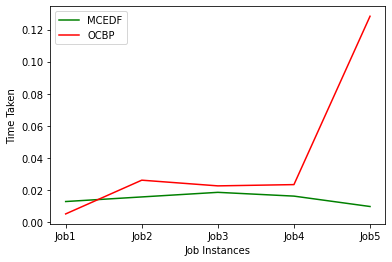

In [ ]:
plt.plot(x,y_mcedf,color='green',label="MCEDF")
plt.plot(x,y_ocbp,color='red',label="OCBP")
plt.xlabel("Job Instances")
plt.ylabel("Time Taken")
plt.legend(loc="upper left")
plt.show()

# Bar Plot to compare schedulable and non schedulable instances

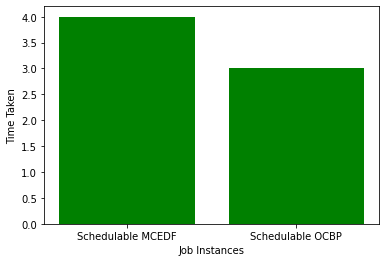

In [ ]:
x=["Schedulable MCEDF","Schedulable OCBP"]
y=[sch_m,sch_o]
plt.bar(x,y,color='green')
plt.xlabel("Job Instances")
plt.ylabel("Time Taken")
plt.show()

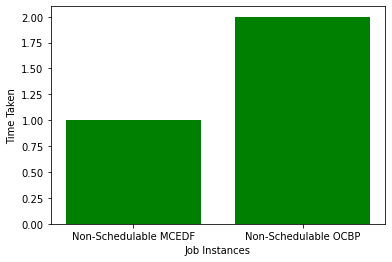

In [ ]:
x=["Non-Schedulable MCEDF","Non-Schedulable OCBP"]
y=[5-sch_m,5-sch_o]
plt.bar(x,y,color='green')
plt.xlabel("Job Instances")
plt.ylabel("Time Taken")
plt.show()

# Results and Observations

- As the author mentioned that the number of schedulable tasks is significantly higher in case of MCEDF when compared to OCBP, this can be very well seen in above plot "Bar Plot to compare schedulable and non schedulable instances". 

- Also the time taken by MCEDF is comparatively lesser when compared to OCBP for average number of cases during our analysis. This also matches with the objective of the paper as mentioned by author.